# Dataloader

In [1]:
from importlib import reload
import IntersectionDataset
reload(IntersectionDataset)
from IntersectionDataset import IntersectionDataset

from torch.utils.data import DataLoader
import multiprocessing
from torchvision.transforms import ToTensor
import torch

import matplotlib.pyplot as plt

In [2]:
dataset_dir = "dataset"
img_transform = ToTensor()
path_transform = ToTensor()
dataset = IntersectionDataset(root_dir=dataset_dir,
                              transform=img_transform,
                              path_transform=path_transform)

In [96]:
def custom_collate_fn(batch):
    """
    Custom collate function that handles the variable-length 'paths' list.
    For the satellite images, we stack them into a tensor.
    For the 'paths' field, we simply collect them into a list.
    """
    satellite_batch = torch.stack([item["satellite"] for item in batch])
    # Keep 'paths' as a list of lists (variable-length) without stacking.
    paths_batch = [item["paths"] for item in batch]
    return {"satellite": satellite_batch, "paths": paths_batch}

In [3]:
# find num_workers
num_workers = multiprocessing.cpu_count()

b = 2
dataloader = DataLoader(dataset, 
                        batch_size=b, 
                        shuffle=True, 
                        num_workers=num_workers)

In [4]:
for batch in dataloader:
    print(batch["satellite"].shape)
    print(batch["path_line"].shape)
    print(batch["ee_data"])
    print(batch["cold_map"])
    break

torch.Size([2, 3, 400, 400])
torch.Size([2, 400, 400])
{'entry': {'x': tensor([399, 399]), 'y': tensor([265, 208])}, 'exit': {'x': tensor([0, 0]), 'y': tensor([244, 232])}}
tensor([[[0.9179, 0.9128, 0.9078,  ..., 0.4883, 0.4927, 0.4972],
         [0.9176, 0.9126, 0.9075,  ..., 0.4883, 0.4927, 0.4972],
         [0.9171, 0.9120, 0.9070,  ..., 0.4884, 0.4928, 0.4972],
         ...,
         [0.9981, 0.9931, 0.9880,  ..., 0.4015, 0.4058, 0.4100],
         [0.9991, 0.9940, 0.9890,  ..., 0.4015, 0.4058, 0.4100],
         [1.0000, 0.9950, 0.9899,  ..., 0.4015, 0.4058, 0.4100]],

        [[1.0000, 0.9942, 0.9884,  ..., 0.6392, 0.6446, 0.6499],
         [0.9995, 0.9937, 0.9880,  ..., 0.6392, 0.6446, 0.6499],
         [0.9991, 0.9933, 0.9875,  ..., 0.6392, 0.6446, 0.6499],
         ...,
         [0.8750, 0.8694, 0.8637,  ..., 0.7585, 0.7640, 0.7695],
         [0.8750, 0.8694, 0.8637,  ..., 0.7587, 0.7642, 0.7697],
         [0.8750, 0.8694, 0.8637,  ..., 0.7589, 0.7644, 0.7699]]])


156


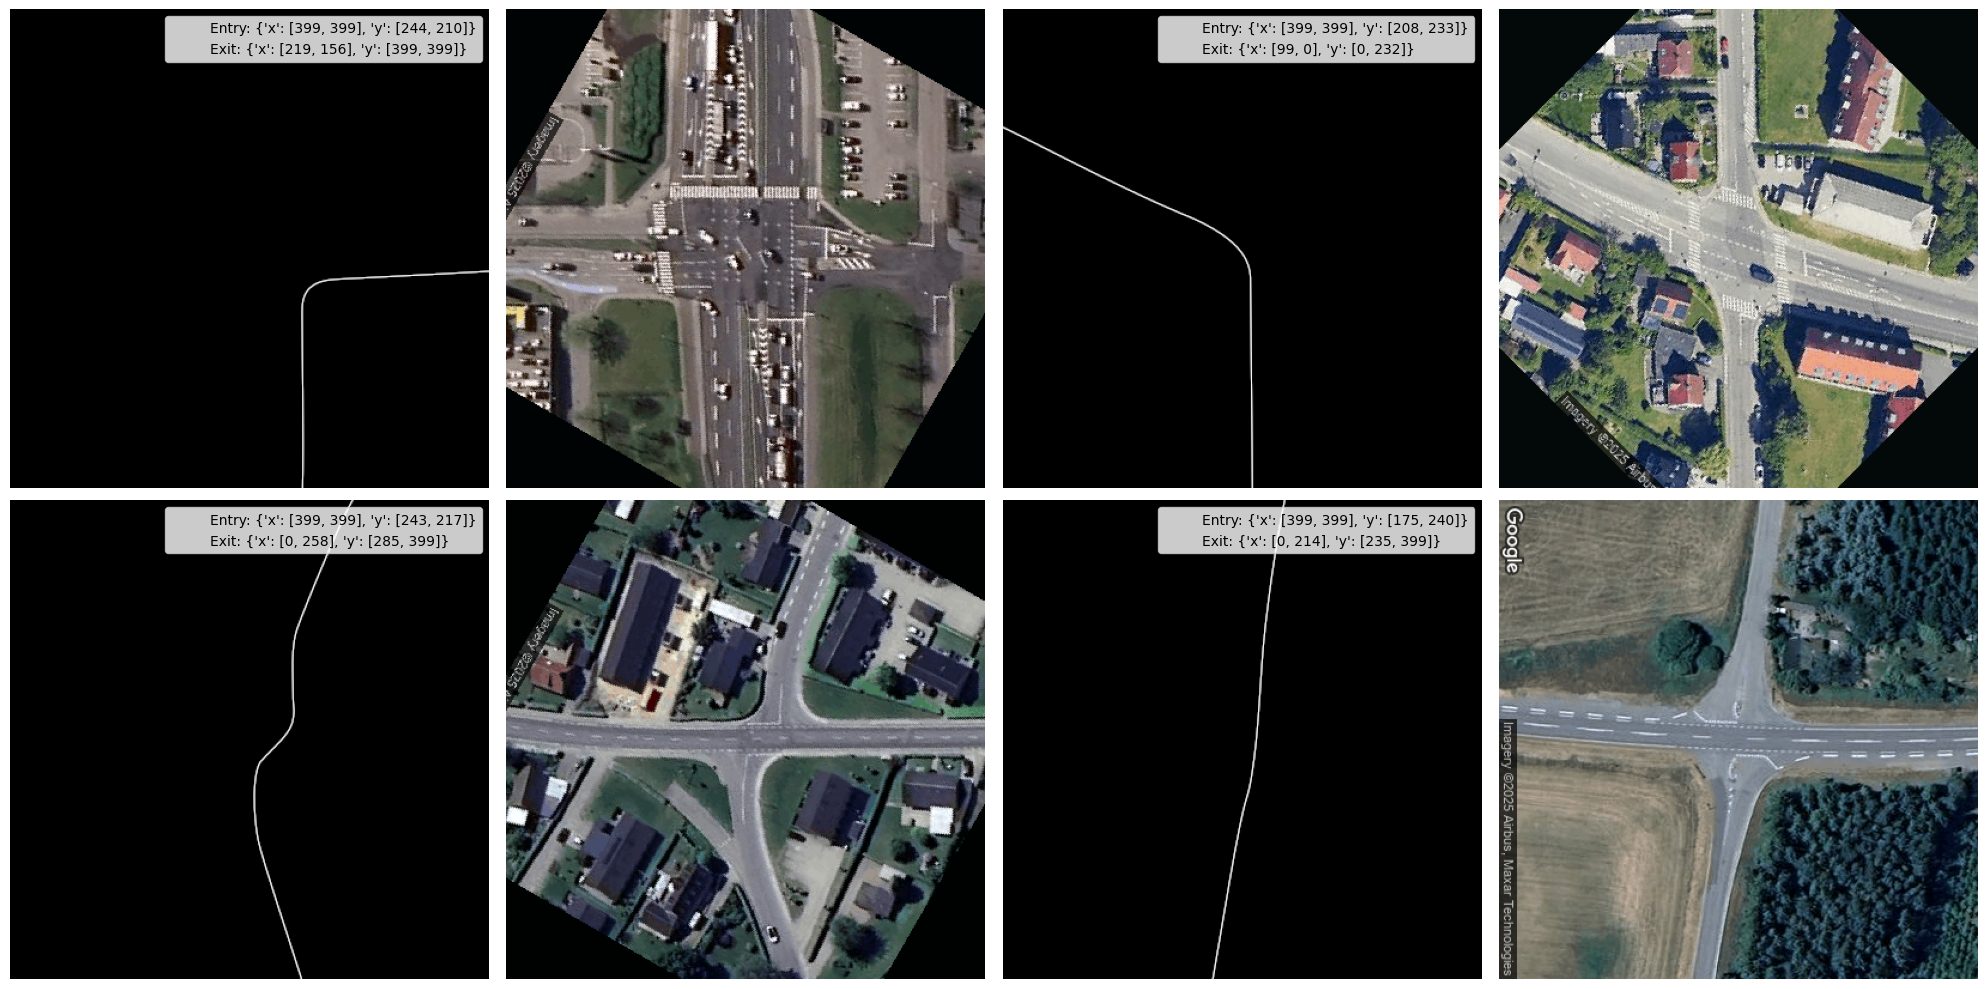

In [118]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(20, 10))
cols, rows = 4, 2
ii = 0
c = 0

for batch in dataloader:
    satellite = batch["satellite"]
    path_line = batch["path_line"]
    ee_data = batch["ee_data"]
    cold_map = batch["cold_map"]
    
    greyscale_image = path_line[0].numpy()
    
    satellite_image = satellite[0].permute(1, 2, 0).numpy()
    
    fig.add_subplot(rows, cols, ii + 1)
    
    #remove tensor from ee_data
    ee_e_x = ee_data['entry']['x'].detach().numpy().tolist()
    ee_e_y = ee_data['entry']['y'].detach().numpy().tolist()
    ee_x_x = ee_data['exit']['x'].detach().numpy().tolist()
    ee_x_y = ee_data['exit']['y'].detach().numpy().tolist()
    ee_data['entry']['x'] = ee_e_x
    ee_data['entry']['y'] = ee_e_y
    ee_data['exit']['x'] = ee_x_x
    ee_data['exit']['y'] = ee_x_y
    legend_elements = [Line2D([0], [0], marker='o', color='w', alpha=0.0, linewidth=0.0, label=f"Entry: {ee_data['entry']}"),
                       Line2D([0], [0], marker='o', color='w', alpha=0.0, linewidth=0.0, label=f"Exit: {ee_data['exit']}"),
                       #Line2D([0], [0], marker='o', color='w', alpha=0.0, linewidth=0.0, label=f"Cold Map Loss: {L_cmap:.2f}"),
                       #Line2D([0], [0], marker='o', color='w', alpha=0.0, linewidth=0.0, label=f"BCE Loss: {L_bce:.2f}")
                       ]
    
    plt.legend(handles=legend_elements, loc='upper right')
    plt.imshow(greyscale_image, cmap='gray')
    plt.axis("off")
    ii += 1   
     
    fig.add_subplot(rows, cols, ii + 1)
    plt.imshow(satellite_image)
    plt.axis("off")
    ii += 1
    

    if ii >= cols * rows:
        break

print(dataset.__len__())

fig.tight_layout()
fig.savefig("img/loader/loader_1.png", transparent=True)

plt.tight_layout()
plt.show()

In [ ]:
# split dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=b, shuffle=True, num_workers=num_workers, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=b, shuffle=True, num_workers=num_workers, collate_fn=custom_collate_fn)

# Loss testing

In [102]:
import sys
import numpy as np
import cv2
from pathlib import Path
from matplotlib.lines import Line2D

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

import importlib
from dataset import dataset_lib as dl
from loss import loss_lib as ll
importlib.reload(ll)
importlib.reload(dl)

<module 'dataset.dataset_lib' from '/mnt/c/Users/ianda/OneDrive/AU/msc/intersection-traversal/dataset/dataset_lib.py'>

In [95]:
Lc = ll.CmapLoss(1/1000)


comp_path = "./img/comp2.png"

cmap_gt = p["cold_map"]

path = cv2.imread(comp_path, cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(path, 1, 1, cv2.THRESH_BINARY)

cmap2 = torch.from_numpy(cmap_gt).float()
cmap_f = torch.flatten(cmap2)

path_np = np.array(path)
path_t = torch.from_numpy(path_np).float().requires_grad_(True)
path_f = torch.flatten(path_t)


L_cmap = Lc(cmap_f, path_f)
L_cmap

tensor(20.4348, grad_fn=<MulBackward0>)

In [96]:
Lb = ll.BCELoss()

ground_truth = p["path_line"].detach().numpy()[0]

prediction = cv2.imread(comp_path, cv2.IMREAD_GRAYSCALE) / 255.0

gt_tensor = torch.from_numpy(ground_truth).float()
p_tensor = torch.from_numpy(prediction).float().requires_grad_(True)

L_bce = Lb(gt_tensor, p_tensor)
L_bce

tensor(0.6076, grad_fn=<MulBackward0>)

torch.Size([400, 400])
Satellite batch type: <class 'torch.Tensor'>
Number of intersections in batch: 2
Number of paths in batch: 2


<Figure size 2000x1000 with 0 Axes>

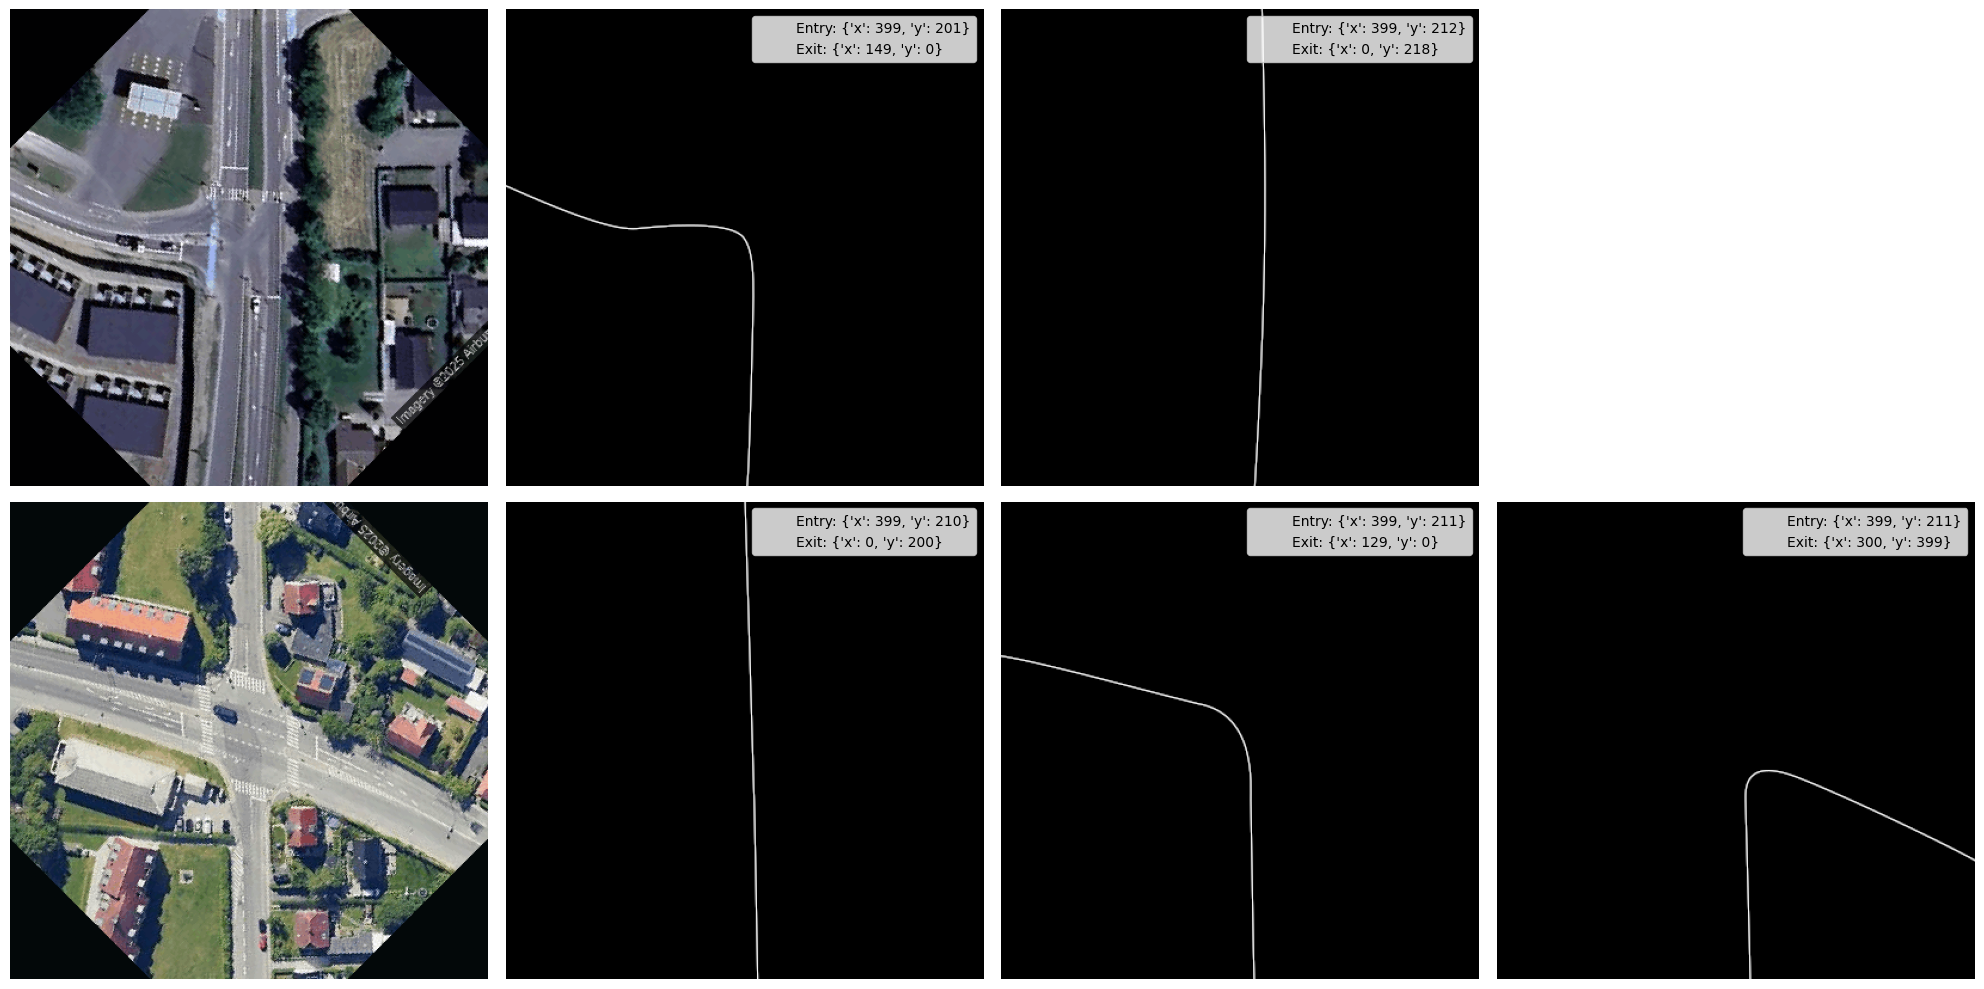

In [119]:
fig = plt.figure(figsize=(20, 10))
cols, rows = 4, b
ii = 0
c = 0

Lc = ll.CmapLoss(1/1000)
Lb = ll.BCELoss()


comp_path = "./img/comp2.png"

path_np = np.array(comp_path)
path = cv2.imread(comp_path, cv2.IMREAD_GRAYSCALE)
path_t = torch.from_numpy(path).float().requires_grad_(True)
path_f = torch.flatten(path_t)

p_tensor = cv2.imread(comp_path, cv2.IMREAD_GRAYSCALE) / 255.0
p_tensor = torch.from_numpy(p_tensor).float().requires_grad_(True)
print(p_tensor.shape)

l = 0
for batch in dataloader:
    fig = plt.figure(figsize=(20, 10))
    cols, rows = 4, b
    ii = 0
    c = 0
    
    # The batch is a dictionary with keys "satellite" and "paths"
    satellite_batch = batch["satellite"]
    paths_batch = batch["paths"]
    print("Satellite batch type:", type(satellite_batch))
    print("Number of intersections in batch:", len(satellite_batch))
    print("Number of paths in batch:", len(paths_batch))
    #print("Paths info for first intersection in batch:", paths_batch[0])
    
    for j in range(len(satellite_batch)):
        if c == 2:
            ii += 1
            
        fig.add_subplot(rows, cols, ii + 1)
        plt.imshow(satellite_batch[j].permute(1, 2, 0))
        plt.axis("off")
        ii += 1
        
        c = 0
        for k, p in enumerate(paths_batch[j]):
            c += 1
            line = p["path_line"]
            # cold map loss
            cmap_gt = p["cold_map"]
            cmap2 = torch.from_numpy(cmap_gt).float()
            cmap_f = torch.flatten(cmap2)
            L_cmap = Lc(cmap_f, path_f)
            
            # bce loss
            gt_tensor = p["path_line"].detach().numpy()[0]
            gt_tensor = torch.from_numpy(gt_tensor).float()
            L_bce = Lb(gt_tensor, p_tensor)
            
            ee = p["ee_data"]
            legend_elements = [Line2D([0], [0], marker='o', color='w', alpha=0.0, linewidth=0.0, label=f"Entry: {ee['entry']}"),
                               Line2D([0], [0], marker='o', color='w', alpha=0.0, linewidth=0.0, label=f"Exit: {ee['exit']}"),
                               #Line2D([0], [0], marker='o', color='w', alpha=0.0, linewidth=0.0, label=f"Cold Map Loss: {L_cmap:.2f}"),
                               #Line2D([0], [0], marker='o', color='w', alpha=0.0, linewidth=0.0, label=f"BCE Loss: {L_bce:.2f}")
                               ]
            
            line = line.detach().numpy()
            grayscale_image = line[0]  # Assuming the first channel represents the grayscale image
            fig.add_subplot(rows, cols, ii + 1)
            plt.legend(handles=legend_elements, loc='upper right')
            #plt.title(f"cold map loss: {L_cmap:.2f}, bce loss: {L_bce:.2f}")
            plt.imshow(grayscale_image, cmap='gray')
            plt.axis("off")
            ii += 1
            
        fig.tight_layout()
        fig.savefig(f"./img/loader/loader_{l}.png", transparent=True)

    
    if l == 0:
        break

    l += 1

plt.tight_layout()
plt.show()